# Assignment 2 (Steam)

### 0. Import packages and define functions

In [1]:
# Import any packages here
import gzip
import pandas as pd
import random
from collections import defaultdict
import numpy as np
from random import choice
from matplotlib import pyplot as plt
from sklearn import linear_model
import math

In [2]:
# Define any functions here
def readCSV(path):
    f = gzip.open(path, 'rt', encoding="utf8")
    values = []
    for line in f:
        fields = eval(line)
        values.append(fields)
    return values

def accuracy(pred, y):
    TP = sum(np.logical_and(pred, y))
    FP = sum(np.logical_and(pred, np.logical_not(y)))
    TN = sum(np.logical_and(np.logical_not(pred), np.logical_not(y)))
    FN = sum(np.logical_and(np.logical_not(pred), y))
    value = (TP + TN) / (TP + FP + TN + FN)
    return value

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return(0)
    else:
        return(numer/denom)

def MSE(predict,y_data):
    diff = predict-np.matrix(y_data)
    differences = [diff[0,i]**2 for i in range(diff.shape[1])]
    mse_test = sum(differences)/len(differences)
    return mse_test

### 1. Read Data

In [3]:
# Load review data
reviews = readCSV("australian_user_reviews.json.gz")
# Retrieve needed columns from review data
user_id, item_id, review, time_posted = [],[],[],[]
for user in reviews:
    uid = user['user_id']
    for item in user['reviews']:
        user_id.append(uid)
        item_id.append(item['item_id'])
        review.append(item['review'])
        time_posted.append(item['posted'][7:])
# Shuffle review data
zip_review = list(zip(user_id, item_id, review, time_posted))
random.seed(1234)
random.shuffle(zip_review)
# Format review data into a dataframe
all_review = pd.DataFrame({'user_id':list(d[0] for d in zip_review), 'item_id':list(d[1] for d in zip_review),
                           'review':list(d[2] for d in zip_review),'time_posted':list(d[3] for d in zip_review)})
# Show what review data look like
all_review[:5]

,user_id,item_id,review,time_posted
0,76561198085013601,250320,"Great game, terrible save system...",February 27.
1,76561198142474106,363620,would be yes if this game didnt cost more than...,"December 7, 2015."
2,bentan312,440,Slapped a guy with a fish.10/10 would do again.,"July 29, 2014."
3,potatoskins,233270,bright colors hurt my eyes10/10 must buy,August 21.
4,Mineturdle321,208090,stupidly addictive,"January 31, 2014."


In [4]:
len(all_review)

59305

In [5]:
# Load user data
aus_users = readCSV("australian_users_items.json.gz")
# Retrieve needed columns from user data
user_id, item_id, item_name, play_time = [],[],[],[]
for user in aus_users:
    uid = user['user_id']
    for item in user['items']:
        user_id.append(uid)
        item_id.append(item['item_id'])
        item_name.append(item['item_name'])
        play_time.append(int(item['playtime_forever']))
# Shuffle user data
zip_data = list(zip(user_id, item_id, item_name, play_time))
random.shuffle(zip_data)
# Format user data into a dataframe
all_user_data = pd.DataFrame({'user_id':list(d[0] for d in zip_data),'item_id':list(d[1] for d in zip_data),
                         'item_name':list(d[2] for d in zip_data),'play_time':list(d[3] for d in zip_data)})
# Show what user data look like
all_user_data = all_user_data[:800000]
all_user_data[:5]

,user_id,item_id,item_name,play_time
0,76561198070316224,301520,Robocraft,3
1,best_luck_ever,320,Half-Life 2: Deathmatch,0
2,76561198071743525,238460,BattleBlock Theater,227
3,76561197994851773,730,Counter-Strike: Global Offensive,3005
4,lecomptedelric,219640,Chivalry: Medieval Warfare,1856


### 2. Split data

In [6]:
## Split data into training set, validation set and test set(0.6,0.2,0.2)
train_user, valid_user, test_user = np.split(all_user_data.sample(frac=1), [int(.6*len(all_user_data)), int(.8*len(all_user_data))])
## Create dictionaries
itemsPerUser, usersPerItem = defaultdict(list), defaultdict(list)
itemCount, usersPlayTime, usersItemCount, usersReview = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)
for m in range(0, len(train_user)):
    u = train_user.iloc[m,0]
    i = train_user.iloc[m,1]
    t = train_user.iloc[m,3]
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)
    itemCount[i] += 1
    usersItemCount[u] += 1
    usersPlayTime[u] += int(t)
n_user = len(itemsPerUser.keys())
n_item = len(usersPerItem.keys())
all_item = list(usersPerItem.keys())
all_user = list(itemsPerUser.keys())
for m in range(0, len(reviews)):
    u = train_user.iloc[m,0]
    usersReview[u] += 1
## Build validation dataset(randomly sample)
valid_u, unbuy = [],[]
all_item_set = set(all_item)
itemsPerUser_set = set(itemsPerUser)
for i in range(0, len(valid_user)):
    user = valid_user.iloc[i,0]
    array = list(all_item_set.difference(set(itemsPerUser[user])))
    unbuy.append(choice(array))
    valid_u.append(user)
valid_data = pd.DataFrame({'user': valid_u,'item': list(valid_user.loc[:, 'item_id']),'buy': 1})
add_data = pd.DataFrame({'user': valid_u,'item': unbuy,'buy': 0})
valid = valid_data.append(add_data)
## Retrieve the most popular items
mostPopular = [(itemCount[x], x) for x in itemCount]
mostPopular.sort()
mostPopular.reverse()

In [7]:
## Create dictionary for review dataset
usersReview = defaultdict(int)
for m in range(0, len(reviews)):
    u = train_user.iloc[m,0]
    usersReview[u] += 1

In [8]:
## Total number of users and items
n_user,n_item

(58143, 8613)

In [9]:
## Shuffle validation set
valid = valid.sample(frac=1).reset_index(drop=True)

## 3.Build model and validate

### 3.1 Baseline model(Half popular only)

In [10]:
## Get accuracy for baseline model (Get the most popular games from our userbase, if game is in top 50% of popular games, predict the user will have bought it)
itemset = set()
count = 0
for ic, i in mostPopular:
    count += ic
    itemset.add(i)
    if count > int(len(train_user)/2): break
predict = []
for i in range(0, len(valid)):
    if valid.iloc[i,1] in itemset:
        predict.append(1)
    else:
        predict.append(0)
n = accuracy(predict, valid["buy"].tolist())
n

0.733840625

### 3.2 Adjusted popular

In [11]:
## Get accuracy for different popu thresholds 
performance = []
for per in np.arange(0.6, 1, 0.05):
    itemset = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        itemset.add(i)
        if count > int(len(train_user)*per): break
    predict = []
    for i in range(0, len(valid)):
        if valid.iloc[i,1] in itemset:
            predict.append(1)
        else:
            predict.append(0)
    n = accuracy(predict, valid["buy"].tolist())
    performance.append(n)

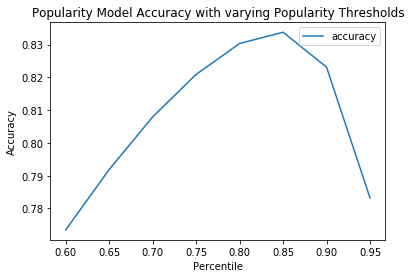

In [12]:
# plot accuracy
percentile = np.arange(0.6, 1, 0.05)
plt.plot(percentile,performance,label = "accuracy")
plt.xlabel("Percentile")
plt.ylabel("Accuracy")
plt.xticks(percentile)
plt.legend(loc="upper right")
plt.title("Popularity Model Accuracy with varying Popularity Thresholds")
plt.show()

In [13]:
p1 = percentile[performance.index(max(performance))]
print('A better threshold is', round(p1*100,2), '%, and the accuracy is', max(performance))

A better threshold is 85.0 %, and the accuracy is 0.8337625


### 3.3 Jaccard similarity only

In [14]:
## Calculate average similarities
avg_sim = []
for i in range(0, len(valid)):
    user = valid.iloc[i,0]
    item = valid.iloc[i,1]
    sim = []
    if user in all_user:
        for items in itemsPerUser[user]: #for every item the user has bought
            s1 = set(usersPerItem[item]) #users that have bought concerned item
            s2 = set(usersPerItem[items]) #users that have bought the item the user has already bought
            value = Jaccard(s1, s2)
            sim.append(value) #Jaccard similarity between users that have bought concerned item and the item that the user has already bought
        v = np.mean(sim) #Mean jaccard similarity
    else:
        v = avg_sim[-1]
    avg_sim.append(v)

In [15]:
## Get accuracy for different thresholds
performance = []
for threshold in np.arange(0, 0.01, 0.002):
    predict = [d>threshold for d in avg_sim] #threshold for mean jaccard similarity
    n = accuracy(predict, valid["buy"].tolist())
    performance.append(n)

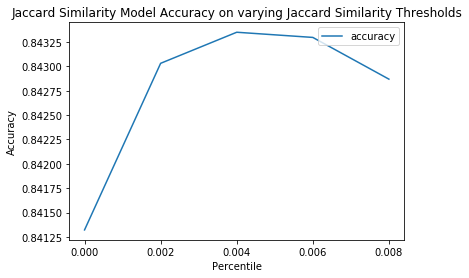

In [30]:
# plot accuracy
percentile = np.arange(0, 0.01, 0.002)
plt.plot(percentile,performance,label = "accuracy")
plt.xlabel("Percentile")
plt.ylabel("Accuracy")
plt.xticks(percentile)
plt.legend(loc="upper right")
plt.title("Jaccard Similarity Model Accuracy on varying Jaccard Similarity Thresholds")
plt.show()

In [17]:
p2 = percentile[performance.index(max(performance))]
print('A better threshold is', p2*100, '%, and the accuracy is', max(performance))

A better threshold is 0.4 %, and the accuracy is 0.8068625


### 3.4 Jaccard similarity * Popular

In [18]:
## Calculate (Jaccard*Popular) values
val = []
for i in range(0, len(valid)):
    user = valid.iloc[i,0]
    item = valid.iloc[i,1]
    n = itemCount[item]*avg_sim[i]
    val.append(n)

In [19]:
## Get accuracy for different thresholds
performance = []
for threshold in np.arange(0.1, 0.2, 0.02):
    predict = [d>threshold for d in val]
    n = accuracy(predict, valid["buy"].tolist())
    performance.append(n)

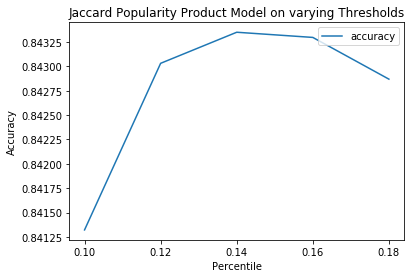

In [31]:
# plot accuracy
percentile = np.arange(0.1, 0.2, 0.02)
plt.plot(percentile,performance,label = "accuracy")
plt.xlabel("Percentile")
plt.ylabel("Accuracy")
plt.xticks(percentile)
plt.legend(loc="upper right")
plt.title("Jaccard Popularity Product Model on varying Thresholds")
plt.show()

In [21]:
p3 = percentile[performance.index(max(performance))]
print('A better threshold is', round(p3,4), ', and the accuracy is', max(performance))

A better threshold is 0.14 , and the accuracy is 0.84335


### 3.5 Logistic regression

In [22]:
## Variables included in Logistic Regression

## 1
## log10(total playtime of a user)
## log(total item bought by a user)
## log(total review given by a user) aka total number of reviews
## Jaccard similarity (same jaccard as before)
## log10(total count per item) aka popularity of item

In [23]:
## Shuffle validation set
valid = valid.sample(frac=1).reset_index(drop=True)
## Build X and y for training and validation
X = []
for i in range(0, len(valid)):
    user = valid.iloc[i,0]
    item = valid.iloc[i,1]
    sim = []
    if user in all_user:
        for items in itemsPerUser[user]:
            s1, s2 = set(usersPerItem[item]), set(usersPerItem[items])
            value = Jaccard(s1, s2)
            sim.append(value)
        avg_sim = np.nanmean(sim)
        ## If avg similarity is nan, assign 0
        if math.isnan(avg_sim) == 1:
            avg_sim = 0
        playtime, n_item, n_review = int(usersPlayTime[user]), usersItemCount[user], usersReview[user]
    ## If the user hasn't appeared before, assign the avg value
    else:
        playtime, n_item = np.mean(list(usersPlayTime.values())), np.mean(list(usersItemCount.values()))
        n_review, avg_sim = np.mean(list(usersReview.values())), 0
    if item in all_item:
        popu = itemCount[item]
    ## If the item hasn't appeared before, assign the avg value
    else:
        popu = np.mean(list(itemCount.values()))
    ## Transfer to log or log10(depending on how large the number is) when value is not 0
    if playtime != 0:
        playtime = math.log10(playtime)
    if n_review != 0:
        n_review = math.log(n_review)
    if n_item != 0:
        n_item = math.log(n_item)
    ## get all variables in x
    x = [1,playtime, n_item, n_review, avg_sim, math.log10(popu)]
    X.append(x)
y = valid["buy"].tolist()

In [24]:
## Split X and y for training and validation
X_train = X[:len(X)//2]
y_train = y[:len(y)//2]
X_valid = X[len(X)//2:]
y_valid = y[len(y)//2:]
## Fit the model
mod = linear_model.LogisticRegression(C=10.0)
mod.fit(X_train, y_train)
valid_pred = mod.predict(X_valid)
accuracy(y_valid, valid_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.84679375

## 4. Test the final model (Logistic Regression)

In [25]:
## Split data into training set and test set(0.8, 0.2)
train_user, test_user = np.split(all_user_data.sample(frac=1), [int(.8*len(all_user_data))])
## Create dictionaries
itemsPerUser, usersPerItem = defaultdict(list), defaultdict(list)
itemCount, usersPlayTime, usersItemCount, usersReview = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)
for m in range(0, len(train_user)):
    u = train_user.iloc[m,0]
    i = train_user.iloc[m,1]
    t = train_user.iloc[m,3]
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)
    itemCount[i] += 1
    usersItemCount[u] += 1
    usersPlayTime[u] += int(t)
n_user = len(itemsPerUser.keys())
n_item = len(usersPerItem.keys())
all_item = list(usersPerItem.keys())
all_user = list(itemsPerUser.keys())
for m in range(0, len(reviews)):
    u = train_user.iloc[m,0]
    usersReview[u] += 1

In [26]:
## Shuffle test set
test_user = test_user.sample(frac=1).reset_index(drop=True)
X = []
y = []
for i in range(0, len(test_user)):
    user = test_user.iloc[i,0]
    item = test_user.iloc[i,1]
    sim = []
    if user in all_user:
        for items in itemsPerUser[user]:
            s1, s2 = set(usersPerItem[item]), set(usersPerItem[items])
            value = Jaccard(s1, s2)
            sim.append(value)
        avg_sim = np.nanmean(sim)
        ## If avg similarity is nan, assign 0
        if math.isnan(avg_sim) == 1:
            avg_sim = 0
        playtime, n_item, n_review = int(usersPlayTime[user]), usersItemCount[user], usersReview[user]
    ## If the user hasn't appeared before, assign the avg value
    else:
        playtime, n_item = np.mean(list(usersPlayTime.values())), np.mean(list(usersItemCount.values()))
        n_review, avg_sim = np.mean(list(usersReview.values())), 0
    if item in all_item:
        popu = itemCount[item]
    ## If the item hasn't appeared before, assign the avg value
    else:
        popu = np.mean(list(itemCount.values()))
    ## Transfer to log or log10(depending on how large the number is) when value is not 0
    if playtime != 0:
        playtime = math.log10(playtime)
    if n_review != 0:
        n_review = math.log(n_review)
    if n_item != 0:
        n_item = math.log(n_item)
    ## get all variables in x
    x = [1,playtime, n_item, n_review, avg_sim, math.log10(popu)]
    X.append(x)
    y.append(1)

In [27]:
## Predict
pred = mod.predict(X)
accuracy(y, pred)

0.9041625

In [36]:
mod.coef_

array([[-2.41672023e+00, -3.79828639e-02,  3.09967167e-01,
         8.67837516e-02,  1.11964372e+02,  2.09964244e+00]])

In [37]:
np.mean(list(usersPlayTime.values())), np.mean(list(usersItemCount.values())),np.mean(list(usersReview.values()))

(10423.74493880442, 10.542441563575865, 0.569376089691245)